In [ ]:
# Import Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import zipfile

In [ ]:
# Extract ZIP file
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
  zip_ref.extractall("data")

In [ ]:
# Set Random Seed for Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Objective 2: Dataset Preparation and Augmentation
DATASET_PATH = 'data/archive'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    classes=['Negative', 'Positive']
)

Found 991 images belonging to 2 classes.


In [ ]:
val_generator = val_test_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=['Negative', 'Positive']
)

Found 991 images belonging to 2 classes.


In [ ]:
test_generator = val_test_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=['Negative', 'Positive']
)

Found 991 images belonging to 2 classes.


In [ ]:
# Objective 3: Design and Conduct Deep Learning Experiments
# Custom CNN
def build_custom_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
cnn_model = build_custom_cnn()
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# MobileNetV2 Model
def build_mobilenetv2():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
mobilenet_model = build_mobilenetv2()
mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# EfficientNetB0
def build_efficientnetb0():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = False  # Freeze base layers initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
efficientnet_model = build_efficientnetb0()
efficientnet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Train Both Models
EPOCHS = 50
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
cnn_history = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.7775 - loss: 0.6104 - val_accuracy: 0.8517 - val_loss: 0.4706
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8512 - loss: 0.4736 - val_accuracy: 0.8517 - val_loss: 0.4342
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8555 - loss: 0.4491 - val_accuracy: 0.8517 - val_loss: 0.4121
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8660 - loss: 0.4007 - val_accuracy: 0.8517 - val_loss: 0.3914
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8571 - loss: 0.3991 - val_accuracy: 0.8517 - val_loss: 0.3691
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8644 - loss: 0.3561 - val_accuracy: 0.8517 - val_loss: 0.3643
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8434 - loss: 0.3507 - val_accuracy: 0.8517 - val_loss: 0.3224
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8536 - loss: 0.3445 - val_accuracy: 0.8517 - val_loss:

In [ ]:
# Train MobileNetV2
mobilenet_history = mobilenet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7747 - loss: 0.5331 - val_accuracy: 0.8517 - val_loss: 0.3656
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8657 - loss: 0.3464 - val_accuracy: 0.8628 - val_loss: 0.2782
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8822 - loss: 0.2773 - val_accuracy: 0.8940 - val_loss: 0.2341
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8926 - loss: 0.2643 - val_accuracy: 0.8981 - val_loss: 0.2155
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8939 - loss: 0.2272 - val_accuracy: 0.9041 - val_loss: 0.2042
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9361 - loss: 0.1867 - val_accuracy: 0.9062 - val_loss: 0.2074
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9236 - loss: 0.2269 - val_accuracy: 0.8971 - val_loss: 0.2202
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9171 - loss: 0.2082 - val_accuracy: 0.9102 - val_loss:

In [ ]:
# Train EfficientNetB0
efficientnet_history = efficientnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8176 - loss: 0.4892 - val_accuracy: 0.8517 - val_loss: 0.4242
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8485 - loss: 0.4480 - val_accuracy: 0.8517 - val_loss: 0.4199
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8517 - loss: 0.4226 - val_accuracy: 0.8517 - val_loss: 0.4211
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8545 - loss: 0.4203 - val_accuracy: 0.8517 - val_loss: 0.4207
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8563 - loss: 0.4278 - val_accuracy: 0.8517 - val_loss: 0.4198
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8469 - loss: 0.4375 - val_accuracy: 0.8517 - val_loss: 0.4205
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8737 - loss: 0.3885 - val_accuracy: 0.8517 - val_loss: 0.4201
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8634 - loss: 0.4079 - val_accuracy: 0.8517 - val_loss:

In [ ]:
# Objective 4: Evaluate Model Performance and Visualize Results
def evaluate_model(model, generator, model_name):
    y_true = generator.classes
    y_pred_prob = model.predict(generator).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{model_name} Evaluation on Test Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Sickle'], yticklabels=['Normal', 'Sickle'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    return y_pred_prob, roc_auc

31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/step

Custom CNN Evaluation on Test Set:
Accuracy: 0.8517
Precision: 0.8517
Recall: 1.0000
F1-Score: 0.9199


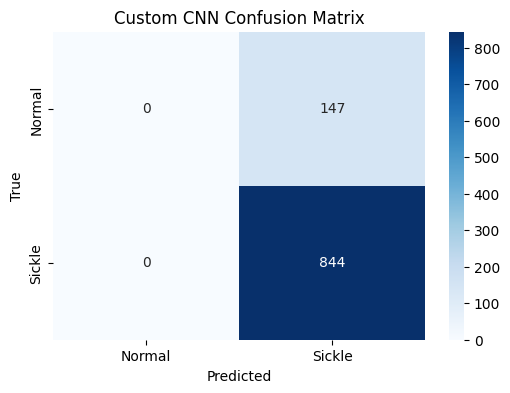

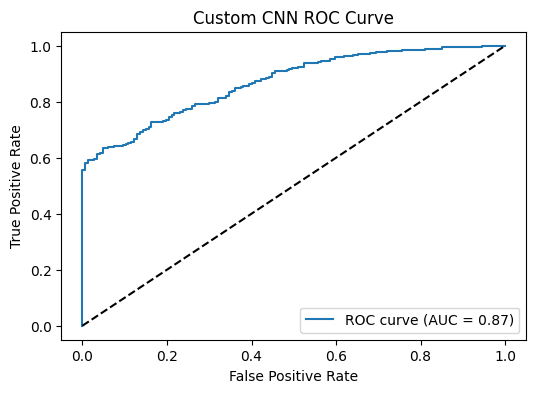

31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 479ms/step

MobileNetV2 Evaluation on Test Set:
Accuracy: 0.9273
Precision: 0.9270
Recall: 0.9929
F1-Score: 0.9588


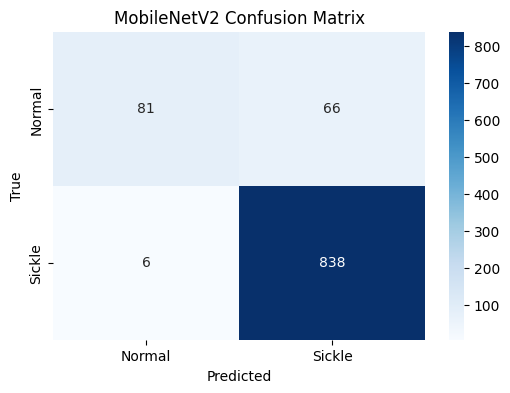

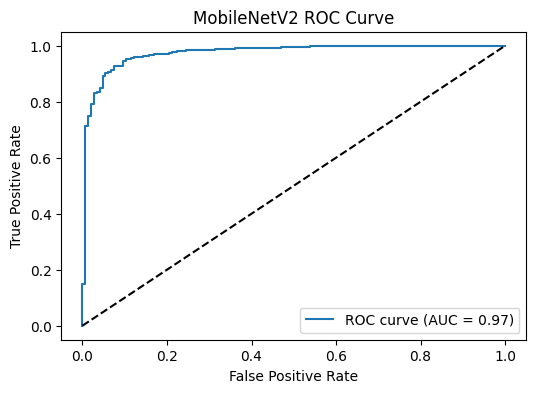

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 581ms/step

EfficientNetB0 Evaluation on Test Set:
Accuracy: 0.8517
Precision: 0.8517
Recall: 1.0000
F1-Score: 0.9199


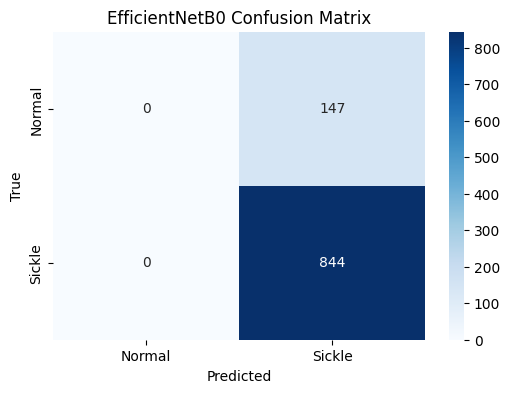

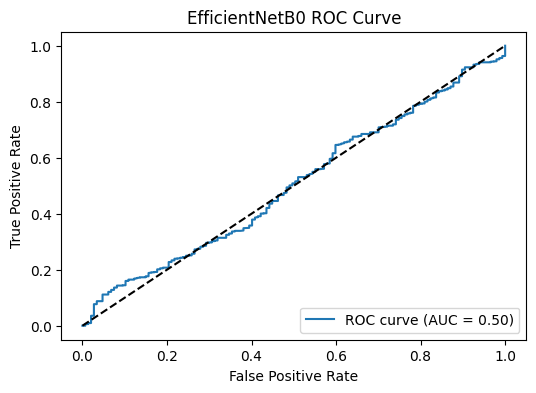

In [ ]:
cnn_pred_prob, cnn_roc_auc = evaluate_model(cnn_model, test_generator, "Custom CNN")
mobilenet_pred_prob, mobilenet_roc_auc = evaluate_model(mobilenet_model, test_generator, "MobileNetV2")
efficientnet_pred_prob, efficientnet_roc_auc = evaluate_model(efficientnet_model, test_generator, "EfficientNetB0")

In [ ]:
# Grad-CAM Visualization
def grad_cam(model, img_array, layer_name, class_idx):
    try:
        if not model.built:
            model(img_array)

        grad_model = tf.keras.models.Model(
            inputs=[model.inputs],
            outputs=[model.get_layer(layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            loss = predictions[:, class_idx]

        grads = tape.gradient(loss, conv_outputs)
        if grads is None:
            print("Gradients could not be computed.")
            return np.zeros((img_array.shape[1], img_array.shape[2]))

        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]

        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0)
        max_val = tf.reduce_max(heatmap)

        if max_val == 0:
            print("Max value of heatmap is 0. Returning blank.")
            heatmap = tf.zeros_like(heatmap)
        else:
            heatmap /= max_val

        heatmap = heatmap.numpy()
        print("Heatmap computed. Shape:", heatmap.shape)

        heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
        return heatmap

    except Exception as e:
        print("Exception in grad_cam:", str(e))
        return np.zeros((img_array.shape[1], img_array.shape[2]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
Exception in grad_cam: The layer sequential has never been called and thus has no defined output.
Final Heatmap shape: (224, 224)


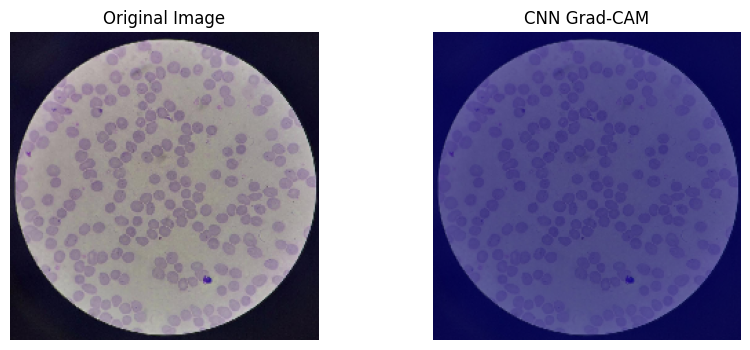

In [ ]:
sample_img, sample_label = next(test_generator)
sample_img = sample_img[0:1]
_ = cnn_model.predict(sample_img)
img_for_display = sample_img[0]

cnn_layer_name = 'conv2d_2'
cnn_heatmap = grad_cam(cnn_model, sample_img, cnn_layer_name, int(sample_label[0]))

print("Final Heatmap shape:", cnn_heatmap.shape)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_for_display)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_for_display)
plt.imshow(cnn_heatmap.astype(np.float32), cmap='jet', alpha=0.5)
plt.title('CNN Grad-CAM')
plt.axis('off')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_11']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Heatmap computed. Shape: (7, 7)


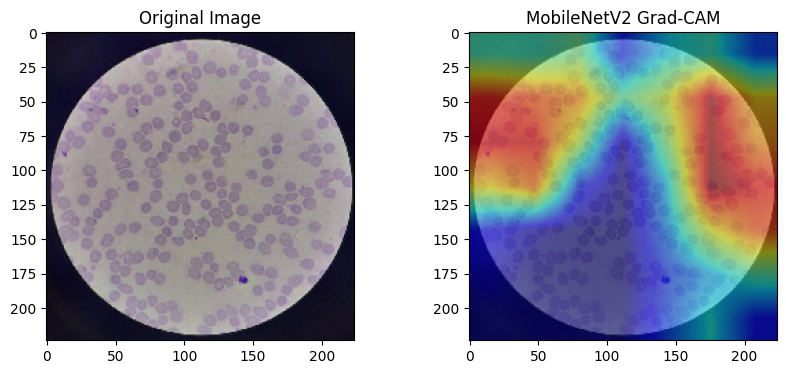

In [ ]:
mobilenet_layer_name = 'Conv_1'
mobilenet_heatmap = grad_cam(mobilenet_model, sample_img, mobilenet_layer_name, int(sample_label[0]))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_for_display)
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(img_for_display)
plt.imshow(mobilenet_heatmap, cmap='jet', alpha=0.5)
plt.title('MobileNetV2 Grad-CAM')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_169']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Heatmap computed. Shape: (7, 7)


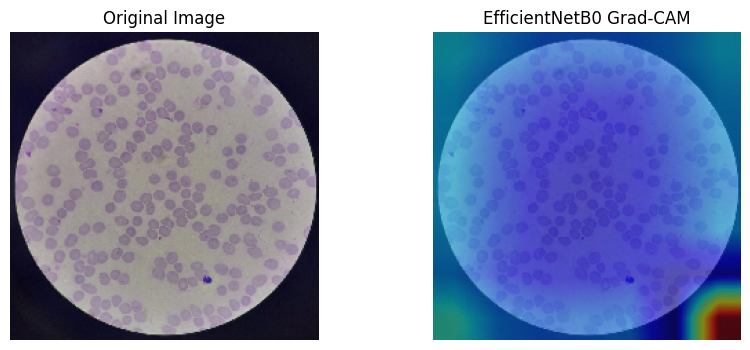

In [ ]:
efficientnet_layer_name = 'top_conv'
efficientnet_heatmap = grad_cam(efficientnet_model, sample_img, efficientnet_layer_name, int(sample_label[0]))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_for_display)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_for_display)
plt.imshow(efficientnet_heatmap, cmap='jet', alpha=0.5)
plt.title('EfficientNetB0 Grad-CAM')
plt.axis('off')
plt.show()

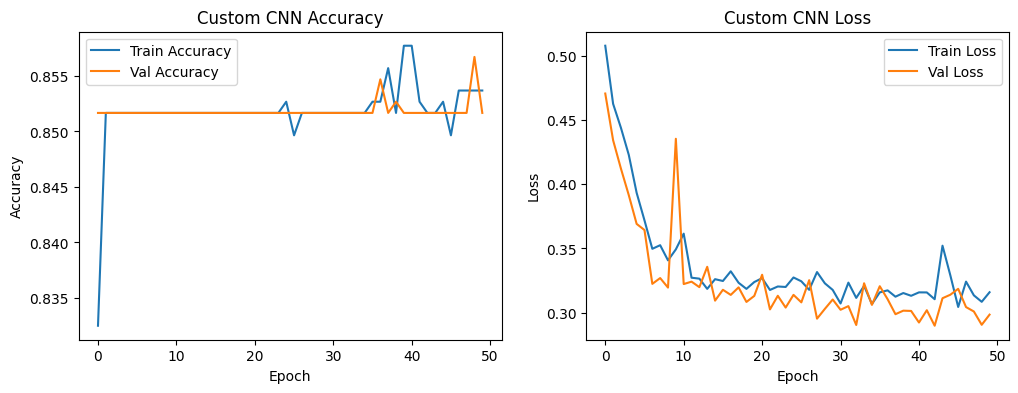

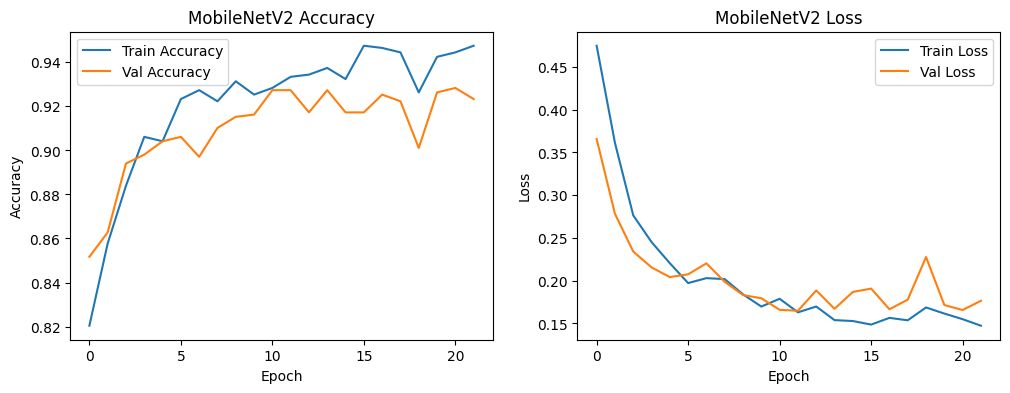

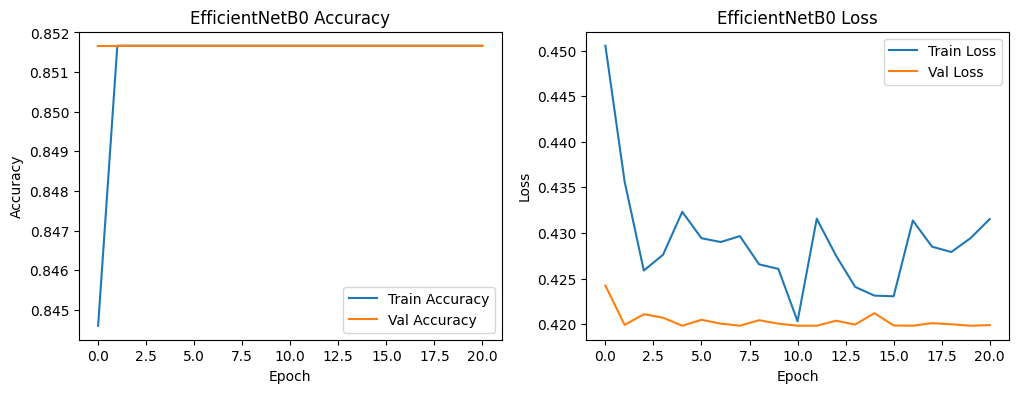

In [ ]:
# Training History Visualization
def plot_history(history, model_name):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(cnn_history, "Custom CNN")
plot_history(mobilenet_history, "MobileNetV2")
plot_history(efficientnet_history, "EfficientNetB0")

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9348 - loss: 0.1721 - val_accuracy: 0.9233 - val_loss: 0.1710
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9401 - loss: 0.1457 - val_accuracy: 0.9203 - val_loss: 0.1769
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9243 - loss: 0.1952 - val_accuracy: 0.9203 - val_loss: 0.1754
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9512 - loss: 0.1479 - val_accuracy: 0.9223 - val_loss: 0.1747
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9386 - loss: 0.1604 - val_accuracy: 0.9213 - val_loss: 0.1750
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9317 - loss: 0.1601 - val_accuracy: 0.9203 - val_loss: 0.1749
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9361 - loss: 0.1628 - val_accuracy: 0.9213 - val_loss: 0.1734
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9397 - loss: 0.1572 - val_accuracy: 0.9223 - val_loss:

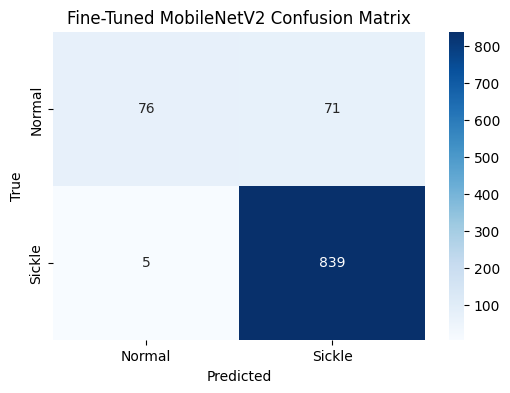

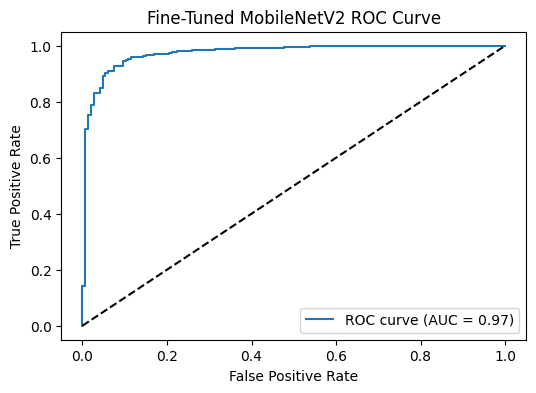

In [ ]:
# Objective 5: Optimize Models for Improved Diagnostic Accuracy
# Hyperparameter Tuning and Fine-Tuning

# Fine-Tune MobileNetV2
mobilenet_model.trainable = True
fine_tune_from = 100  # Fine-tune from this layer onwards
for layer in mobilenet_model.layers[:fine_tune_from]:
    layer.trainable = False

# Recompile with Lower Learning Rate
mobilenet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-Tune
mobilenet_fine_tune_history = mobilenet_model.fit(
    train_generator,
    epochs=20,  # Fewer epochs for fine-tuning
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)

# Re-evaluate Fine-Tuned MobileNetV2
mobilenet_fine_tune_pred_prob, mobilenet_fine_tune_roc_auc = evaluate_model(mobilenet_model, test_generator, "Fine-Tuned MobileNetV2")


In [ ]:
# Hyperparameter Tuning for Custom CNN with different Dropout Rates
dropout_rates = [0.3, 0.5, 0.7]
best_f1 = 0
best_dropout = 0
best_cnn_model = None

for dropout_rate in dropout_rates:
    temp_model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    temp_model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    temp_history = temp_model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping],
        verbose=1
    )
    y_pred_prob = temp_model.predict(test_generator).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
    f1 = f1_score(test_generator.classes, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_dropout = dropout_rate
        best_cnn_model = temp_model

print(f"Best Dropout Rate for CNN: {best_dropout}, F1-Score: {best_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8517 - loss: 1.1091 - val_accuracy: 0.8517 - val_loss: 0.4650
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8533 - loss: 0.4461 - val_accuracy: 0.8517 - val_loss: 0.4138
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8558 - loss: 0.4189 - val_accuracy: 0.8517 - val_loss: 0.4012
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8430 - loss: 0.4415 - val_accuracy: 0.8517 - val_loss: 0.4766
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8416 - loss: 0.4442 - val_accuracy: 0.8517 - val_loss: 0.3366
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8490 - loss: 0.3829 - val_accuracy: 0.8517 - val_loss: 0.3304
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8485 - loss: 0.3673 - val_accuracy: 0.8517 - val_loss: 0.3470
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8408 - loss: 0.4038 - val_accuracy: 0.8517 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7552 - loss: 0.8716 - val_accuracy: 0.8517 - val_loss: 0.4269
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8718 - loss: 0.4156 - val_accuracy: 0.8517 - val_loss: 0.4157
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8631 - loss: 0.4090 - val_accuracy: 0.8517 - val_loss: 0.4000
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8491 - loss: 0.4242 - val_accuracy: 0.8517 - val_loss: 0.3691
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8434 - loss: 0.3993 - val_accuracy: 0.8517 - val_loss: 0.3444
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8471 - loss: 0.3545 - val_accuracy: 0.8517 - val_loss: 0.3584
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8597 - loss: 0.3343 - val_accuracy: 0.8517 - val_loss: 0.3217
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8607 - loss: 0.3146 - val_accuracy: 0.8517 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7984 - loss: 0.5802 - val_accuracy: 0.8517 - val_loss: 0.4208
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8448 - loss: 0.4524 - val_accuracy: 0.8517 - val_loss: 0.4134
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8428 - loss: 0.4660 - val_accuracy: 0.8517 - val_loss: 0.4744
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8677 - loss: 0.3830 - val_accuracy: 0.8517 - val_loss: 0.6149
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8643 - loss: 0.3790 - val_accuracy: 0.8517 - val_loss: 0.3410
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8505 - loss: 0.3729 - val_accuracy: 0.8517 - val_loss: 0.5571
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8630 - loss: 0.3914 - val_accuracy: 0.8517 - val_loss: 0.3474
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8605 - loss: 0.3753 - val_accuracy: 0.8517 - val_loss:

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.8704 - loss: 0.3942 - val_accuracy: 0.8517 - val_loss: 0.4199
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8506 - loss: 0.4258 - val_accuracy: 0.8517 - val_loss: 0.4199
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8476 - loss: 0.4379 - val_accuracy: 0.8517 - val_loss: 0.4199
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8515 - loss: 0.4342 - val_accuracy: 0.8517 - val_loss: 0.4198
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8529 - loss: 0.4266 - val_accuracy: 0.8517 - val_loss: 0.4198
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8594 - loss: 0.4237 - val_accuracy: 0.8517 - val_loss: 0.4198
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8490 - loss: 0.4264 - val_accuracy: 0.8517 - val_loss: 0.4198
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8522 - loss: 0.4266 - val_accuracy: 0.8517 - val_loss:

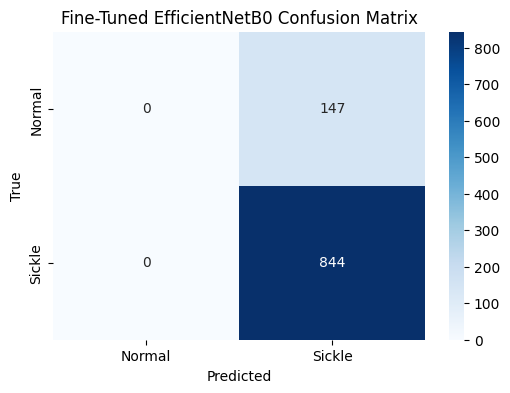

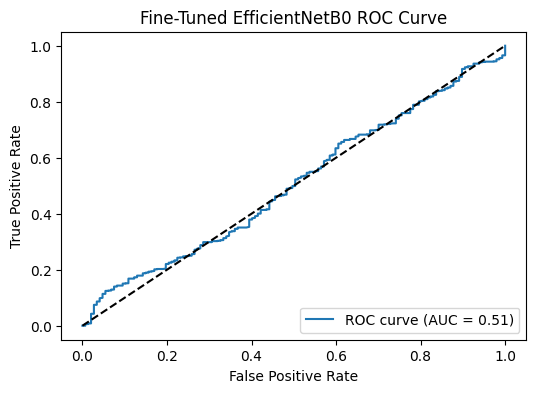

In [ ]:
# Hyperparameter Tunning of efficientNetB0

efficientnet_model.trainable = True
fine_tune_from = 150  # Unfreeze from layer 150 upwards (EfficientNet is deeper than MobileNet)

for layer in efficientnet_model.layers[:fine_tune_from]:
    layer.trainable = False

efficientnet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

efficientnet_fine_tune_history = efficientnet_model.fit(
    train_generator,
    epochs=20,  # Fine-tuning usually needs fewer epochs
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)

efficientnet_fine_tune_pred_prob, efficientnet_fine_tune_roc_auc = evaluate_model(
    efficientnet_model, test_generator, "Fine-Tuned EfficientNetB0"
)

In [ ]:
# Save Models
best_cnn_model.save('best_cnn_model.h5')
mobilenet_model.save('fine_tuned_mobilenetv2_model.h5')
efficientnet_model.save('fine_tuned_efficientnetB0_model.h5')

In [ ]:
# Final Comparison
print("\nFinal Model Comparison:")
print(f"Custom CNN (Best Dropout {best_dropout}) - Test F1-Score: {best_f1:.4f}")
print(f"Fine-Tuned MobileNetV2 - Test AUC: {mobilenet_fine_tune_roc_auc:.4f}")
print(f"Fine-Tuned EfficientNetB0 - Test AUC: {efficientnet_fine_tune_roc_auc:.4f}")


Final Model Comparison:
Custom CNN (Best Dropout 0.3) - Test F1-Score: 0.9199
Fine-Tuned MobileNetV2 - Test AUC: 0.9735
Fine-Tuned EfficientNetB0 - Test AUC: 0.5066
